## RNN ile Havayolu Yolcu Sayısı Tahmini

In [ ]:
#1) İş Problemi (Business Problem)

In [ ]:
# Month: Aylık olarak yer alan tarih değişkenidir.
# Passengers: İlgili işlem tarihindeki yolcu sayısını, yani aylık yolcu sayısını temsil etmektedir.

In [1]:
# Veri Seti https://www.kaggle.com/datasets/andreazzini/international-airline-passengers

In [ ]:
# 2) Veriyi Anlamak (Data Understanding)

In [ ]:
# Import

In [ ]:
# Veriyi okuma ve işleme adımında kullanılacak olan kütüphaneler import numpy as np
import pandas as pd
import numpy as np
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt
# Model değerlendirme ve veriyi scale edebilmemiz için kullanılacak olan kütüphaneler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# Model için kullanılacak olan kütüphaneler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# Warningleri kapatmak için kullanılmaktadır.
import warnings
warnings.filterwarnings ('ignore')
# Tensorflow Warning Engelleme 
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1. logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
# Veri Setinin Yüklenmesi

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
dir_path="/content/drive/MyDrive/Colab Notebooks"
df = pd.read_csv(dir_path+"/international-airline-passengers.csv")

In [ ]:
df.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [ ]:
df.columns

Index(['Month', 'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], dtype='object')

In [ ]:
df.columns=["Month","Passengers"]

In [ ]:
df.head()

,Month,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [ ]:
df.tail()

,Month,Passengers
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0
144,International airline passengers: monthly tota...,NaN


In [ ]:
df.shape

(145, 2)

In [ ]:
df.dtypes

Month          object
Passengers    float64
dtype: object

In [ ]:
df.isnull().sum()

Month         0
Passengers    1
dtype: int64

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


In [ ]:
# 3) Veriyi Hazırlamak (Data Preparation)

In [ ]:
df=df[:144]

In [ ]:
df.tail()

,Month,Passengers
139,1960-08,606.0
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month       144 non-null    object 
 1   Passengers  144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.4+ KB


In [ ]:
df["Month"]=pd.to_datetime(df["Month"])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB


In [ ]:
print("Min Tarih:",df["Month"].min())
print("Max Tarih:",df["Month"].max())

Min Tarih: 1949-01-01 00:00:00
Max Tarih: 1960-12-01 00:00:00


In [ ]:
df.index=df["Month"]

In [ ]:
df.head()

,Month,Passengers
Month,,
1949-01-01,1949-01-01,112.0
1949-02-01,1949-02-01,118.0
1949-03-01,1949-03-01,132.0
1949-04-01,1949-04-01,129.0
1949-05-01,1949-05-01,121.0


In [ ]:
df.drop("Month",axis=1,inplace=True)
#axis 1 sutun

In [ ]:
df.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [ ]:
result_df=df.copy()

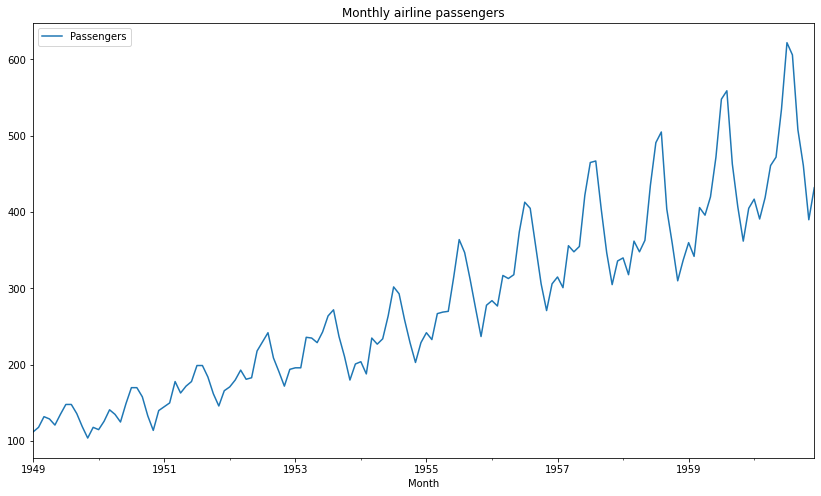

In [ ]:
df.plot(figsize=(14,8),title="Monthly airline passengers");

In [ ]:
data = df["Passengers"].values

In [ ]:
data[0:10]

array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119.])

In [ ]:
type(data)  

numpy.ndarray

In [ ]:
type(data[0])

numpy.float64

In [ ]:
data =data.astype("float32")

In [ ]:
type(data[0])

numpy.float32

In [ ]:
data.shape

(144,)

In [ ]:
data=data.reshape(-1,1)

In [ ]:
data.shape

(144, 1)

In [ ]:
# zaman seti oldugu icin rastgele bolersek oruntu kayboluyor bu yuzden kendimiz yapacagız

In [ ]:
def split_data(dataframe,test_size):
  position=int(round(len(dataframe)*(1-test_size)))
  train=dataframe[:position]
  test=dataframe[position:]
  return train, test, position

In [ ]:
train, test,position=split_data(data,0.33)

In [ ]:
print(train.shape,test.shape)

(96, 1) (48, 1)


In [ ]:
scaler_train=MinMaxScaler(feature_range=(0,1))

In [ ]:
train=scaler_train.fit_transform(train)

In [ ]:
# donusturme isleminde oruntunun yansıma sorununu cozmek icin yapılır Data Leakage

In [ ]:
scaler_test=MinMaxScaler(feature_range=(0,1))

In [ ]:
test=scaler_test.fit_transform(test)

In [ ]:
train[0:5]

array([[0.02588999],
       [0.04530746],
       [0.09061491],
       [0.08090615],
       [0.05501619]], dtype=float32)

In [ ]:
test[0:5]

array([[0.04361373],
       [0.        ],
       [0.17133951],
       [0.1464175 ],
       [0.16822433]], dtype=float32)

In [ ]:
# ay a gore yapıyor olacagız

In [ ]:
def create_features(data,lookback):
  X, Y=[],[]
  for i in range(lookback,len(data)):
    X.append(data[i-lookback:i,0])
    Y.append(data[i,0])
  
  return np.array(X), np.array(Y)

In [ ]:
lookback=1

In [ ]:
#Train 
X_train,y_train=create_features(train,lookback)

In [ ]:
#Test
X_test,y_test=create_features(test,lookback)

In [ ]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(95, 1) (95,) (47, 1) (47,)


In [ ]:
# 1 lookback yaptıgımız icin test ve train setinde eksik oldu

In [ ]:
# rnn 3 boyutlu ister

In [ ]:
X_train=np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
X_test=np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))
y_train=y_train.reshape(-1,1)
y_test=y_test.reshape(-1,1)

In [ ]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(95, 1, 1) (95, 1) (47, 1, 1) (47, 1)


In [ ]:
# 4) Modelleme (Modeling)

In [ ]:
model=Sequential()

model.add(SimpleRNN(units=50,
                    activation="relu",
                    input_shape=(X_train.shape[1],lookback)
                    ))
model.add(Dropout(0.2))
model.add(Dense(1))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2600      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# optimizasyon ve degerlendirme metrikleri

In [ ]:
model.compile(loss="mean_squared_error",optimizer="adam")
# bircok loss fonksiyonu belirlenebilir
# optimizer farklı denenebilir

In [ ]:
callbacks=[EarlyStopping(monitor="val_loss",patience=3,verbose=1,mode="min"),
           ModelCheckpoint(filepath="mymodel.h5",monitor="val_loss",mode="min",save_best_only=True,save_weights_only=False,verbose=1)]

In [ ]:
history=model.fit(x=X_train,
                  y=y_train,
                  epochs=100,
                  batch_size=1,
                  validation_data=(X_test,y_test),
                  callbacks=callbacks,
                  shuffle=False
                  )

Epoch 1/100
95/95 [==============================] - ETA: 0s - loss: 0.0141
Epoch 1: val_loss improved from inf to 0.03871, saving model to mymodel.h5
95/95 [==============================] - 2s 7ms/step - loss: 0.0141 - val_loss: 0.0387
Epoch 2/100
75/95 [======================>.......] - ETA: 0s - loss: 0.0174
Epoch 2: val_loss improved from 0.03871 to 0.02475, saving model to mymodel.h5
95/95 [==============================] - 0s 3ms/step - loss: 0.0179 - val_loss: 0.0248
Epoch 3/100
76/95 [=======================>......] - ETA: 0s - loss: 0.0113
Epoch 3: val_loss improved from 0.02475 to 0.02209, saving model to mymodel.h5
95/95 [==============================] - 0s 3ms/step - loss: 0.0141 - val_loss: 0.0221
Epoch 4/100
93/95 [============================>.] - ETA: 0s - loss: 0.0131
Epoch 4: val_loss did not improve from 0.02209
95/95 [==============================] - 0s 3ms/step - loss: 0.0130 - val_loss: 0.0233
Epoch 5/100
74/95 [======================>.......] - ETA: 0s - loss:

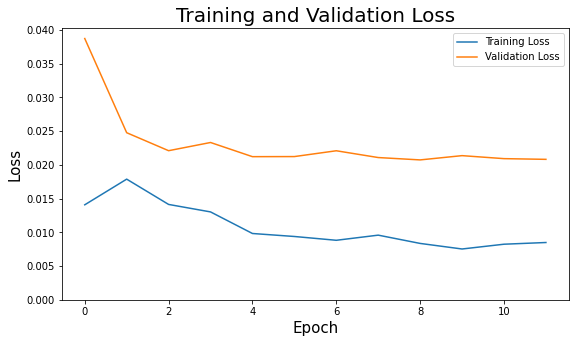

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history["loss"],label="Training Loss")
plt.plot(history.history["val_loss"],label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel("Epoch",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.ylim([0,max(plt.ylim())])
plt.title("Training and Validation Loss",fontsize=20)
plt.show()

In [ ]:
# 5) Değerlendirme (Evaluation)

In [ ]:
loss=model.evaluate(X_test,y_test,batch_size=1)

47/47 [==============================] - 0s 2ms/step - loss: 0.0208


In [ ]:
print("Test Loss: %.1f%%"%(100.0*loss))

Test Loss: 2.1%


In [ ]:
# mse degeri yani

In [ ]:
train_predict=model.predict(X_train)

3/3 [==============================] - 0s 5ms/step


In [ ]:
test_predict=model.predict(X_test)

2/2 [==============================] - 0s 8ms/step


In [ ]:
train_predict=scaler_train.inverse_transform(train_predict)
test_predict=scaler_test.inverse_transform(test_predict)

In [ ]:
y_train=scaler_train.inverse_transform(y_train)
y_test=scaler_test.inverse_transform(y_test)

In [ ]:
train_rmse=np.sqrt(mean_squared_error(y_train,train_predict))

In [ ]:
test_rmse=np.sqrt(mean_squared_error(y_test,test_predict))

In [ ]:
# rmse yani

In [ ]:
print(f"Train RMSE :{train_rmse}")
print(f"Test RMSE :{test_rmse}")

Train RMSE :23.04957389831543
Test RMSE :46.30608367919922


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


In [ ]:
# 300 yolcu ise +- 46 gibi düsünebiliriz

In [ ]:
result_df

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
...,...
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,461.0


In [ ]:
train_prediction_df=result_df[lookback:position]

In [ ]:
train_prediction_df["Predicted"]=train_predict

In [ ]:
train_prediction_df.head()

,Passengers,Predicted
Month,,
1949-02-01,118.0,130.171158
1949-03-01,132.0,132.789658
1949-04-01,129.0,142.724701
1949-05-01,121.0,140.312469
1949-06-01,135.0,134.705475


In [ ]:
test_prediction_df=result_df[position+lookback:]
test_prediction_df["Predicted"]=test_predict
test_prediction_df.head()

,Passengers,Predicted
Month,,
1957-02-01,301.0,330.645874
1957-03-01,356.0,325.601471
1957-04-01,348.0,364.471375
1957-05-01,355.0,356.953766
1957-06-01,422.0,363.531677


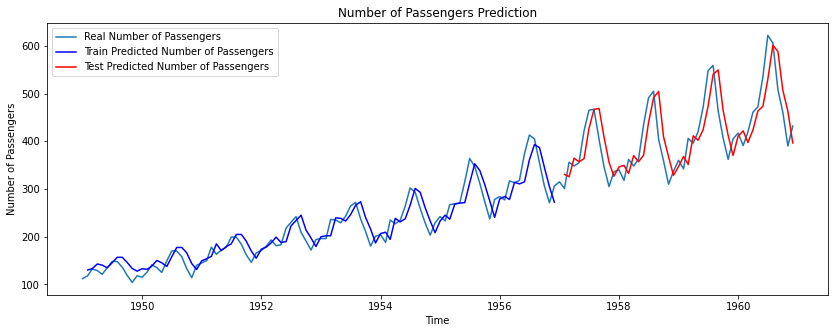

In [ ]:
# Train test tahminlerini görselleştirme

plt.figure(figsize=(14,5))
plt.plot(result_df,label="Real Number of Passengers")
plt.plot(train_prediction_df["Predicted"],color="blue",label="Train Predicted Number of Passengers")
plt.plot(test_prediction_df["Predicted"],color="red",label="Test Predicted Number of Passengers")
plt.title("Number of Passengers Prediction")
plt.xlabel("Time")
plt.ylabel("Number of Passengers")
plt.legend()
plt.show()